In [44]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import numpy as np
from preprocess.VoiceBankDEMAND import VoiceBandDEMAND
from preprocess.feature_extractor import FeatureExtractor
from src.utils import read_audio, load_yaml

# Load the TensorBoard notebook extension.
# %load_ext tensorboard

from tensorflow.python.client import device_lib
import keras.models

# SHOULD PUT model path
model_path = Path(f'./result/lstm/20221103-213029_topdb100_mae')
path_conf = os.path.join(model_path, "config.yaml")
args = load_yaml(path_conf)

Found GPU at: /device:GPU:0


2022-11-17 16:02:25.898120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 16:02:25.898147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [45]:
# 1. Set Paramter
device_lib.list_local_devices()
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

model_name = args.model.name
domain = args.dset.domain
nfft = args.dset.n_fft
win_length = args.dset.win_length
hop_length = args.dset.hop_length
center = args.dset.center
num_feature = args.dset.n_feature
num_segment = args.dset.n_segment
sample_rate = args.dset.sample_rate
center = args.dset.center

# 2. Load data
if args.dset.top_db > args.dset.max_db: # 16bit
    path_to_dataset = f"{args.dset.save_path}_{args.model.name}_{args.dset.domain}"
else:
    path_to_dataset = f"{args.dset.save_path}_{args.model.name}_{args.dset.domain}_{args.dset.top_db}topdb"

print("Data path: ", path_to_dataset)

# 3. Build model
if model_name == "lstm":
    from src.lstm import build_model_lstm
    model = build_model_lstm(args)
else:
    raise ValueError("Model didn't implement...")
model.summary()

Data path:  ./preprocess/data_lstm_freq


2022-11-17 16:02:25.998549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 16:02:25.998577: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 2, 1, 64, 2  0           []                               
                                57)]                                                              
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, 1, 64, 257)  0           ['input[0][0]']                  
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.squeeze_3 (TFOpLa  (None, 64, 257)     0           ['tf.__operators__.getitem_6[0][0
 mbda)                                                           ]']                        

In [46]:
# Model load
model = keras.models.load_model(model_path / "model", compile=False)

In [47]:
dataset_path = args.dset.wav

dataset_voicebank = VoiceBandDEMAND(dataset_path, val_dataset_percent=0.3)
clean_test_filenames, noisy_test_filenames = dataset_voicebank.get_test_filenames()

# SHOULD select file
clean_file = clean_test_filenames[3] 
noisy_file = noisy_test_filenames[3]

clean_file = "/Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_005.wav"
noisy_file = "/Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_005.wav"

# clean_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/clean.wav"
# noisy_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/dirty.wav"

print("Clean: ", clean_file)
print("Noisy: ", noisy_file)

clean_audio, sr = read_audio(clean_file, sample_rate)
noisy_audio, sr = read_audio(noisy_file, sample_rate)

clean_audio_feature_extractor = FeatureExtractor(clean_audio, windowLength=win_length, overlap=hop_length, sample_rate=sr)
stft_features = clean_audio_feature_extractor.get_stft_spectrogram(center)
stft_features = np.abs(stft_features)

print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

noise_audio_feature_extractor = FeatureExtractor(noisy_audio, windowLength=win_length, overlap=hop_length, sample_rate=sr)
noise_stft_features = noise_audio_feature_extractor.get_stft_spectrogram(center)

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
# noisy_phase = np.angle(noise_stft_features)
# noise_stft_features = np.abs(noise_stft_features)

# mean = np.mean(noise_stft_features)
# std = np.std(noise_stft_features)
# noise_stft_features = (noise_stft_features - mean) / std


File example:
Clean:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_001.wav The number:  824
Noisy:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_001.wav The number:  824
# of Noise testing files: 824
Clean:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/clean_testset_wav/p232_005.wav
Noisy:  /Users/seunghyunoh/workplace/study/NoiseReduction/Tiny-SpeechEnhancement/data/VoiceBankDEMAND/DS_10283_2791/noisy_testset_wav/p232_005.wav
Min: 1.3780401e-06 Max: 19.8487


In [48]:
def _prepare_input_features(stft_features, numSegments, numFeatures):
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments
  

def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    if model_name == 'cnn':
        phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noise_audio_feature_extractor.get_audio_from_stft_spectrogram(features, center)


if model_name == "cnn":
    predictors = _prepare_input_features(noise_stft_features, num_segment, num_feature)
    predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
    predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
    estimation_stft = model.predict(predictors)

elif model_name == "lstm":
  predictors_amp = _prepare_input_features(noise_stft_features, num_segment, num_feature)
  predictors_amp = np.reshape(predictors_amp, (predictors_amp.shape[0], predictors_amp.shape[1], predictors_amp.shape[2]))
  predictors_amp = np.transpose(predictors_amp, (2, 0, 1)).astype(np.float32)
  predictors_amp = np.transpose(predictors_amp, (0, 2, 1))

  predictors_phase = _prepare_input_features(noisy_phase, num_segment, num_feature)
  predictors_phase = np.reshape(predictors_phase, (predictors_phase.shape[0], predictors_phase.shape[1], predictors_phase.shape[2]))
  predictors_phase = np.transpose(predictors_phase, (2, 0, 1)).astype(np.float32)
  predictors_phase = np.transpose(predictors_phase, (0, 2, 1))

  predictors = np.stack([predictors_amp, predictors_phase], axis=1)
  predictors = np.expand_dims(predictors, axis=2)

  estimation_stft = model.predict(predictors)
  estimation_stft = estimation_stft[..., -1, :]
  estimation_stft = np.squeeze(estimation_stft)

# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

if model_name == 'cnn':
    estimation = revert_features_to_audio(estimation_stft, noisy_phase, mean, std)
elif model_name == 'lstm':
    estimation = revert_features_to_audio(estimation_stft[:, 0, :], estimation_stft[:, 1, :], mean, std)

print("Min:", np.min(estimation),"Max:",np.max(estimation))
# ipd.Audio(data=estimation, rate=fs) # load a local WAV file

print(estimation.shape)

2022-11-17 16:02:29.745037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 16:02:29.895803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 16:02:30.040194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 49ms/step
Min: -0.21986938 Max: 0.1855611
(99840,)


Text(0.5, 1.0, 'Denoised Audio')

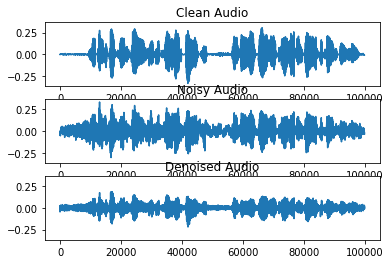

In [49]:
# plot
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(clean_audio)
ax1.set_title("Clean Audio")

ax2.plot(noisy_audio)
ax2.set_title("Noisy Audio")

ax3.plot(estimation)
ax3.set_title("Denoised Audio")


In [50]:
import IPython.display as ipd
ipd.Audio(data=estimation, rate=sample_rate) # load a local WAV file

In [51]:
ipd.Audio(data=clean_audio, rate=sample_rate) # load a local WAV file

In [52]:
ipd.Audio(data=noisy_audio, rate=sample_rate) # load a local WAV file

In [53]:
import numpy as np
import librosa
import librosa.display

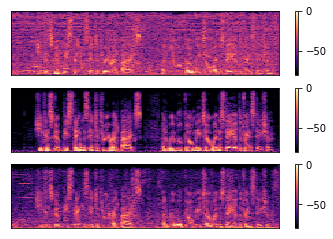

In [54]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharey=True)

def show_stft(y, _fig, _ax):
    D = librosa.stft(y)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, ax=_ax)
    _fig.colorbar(img, ax=_ax)

show_stft(estimation, fig, ax0)
show_stft(clean_audio, fig, ax1)
show_stft(noisy_audio, fig, ax2)

In [55]:
# bose_file = "/home/daniel0413/workplace/project/SpeechEnhancement/example/sample_compare/441c020r/proc.wav"
# boseAudio, sr = read_audio(bose_file, sample_rate)
# ipd.Audio(data=boseAudio, rate=sample_rate)